# 6.5 Lab: Linear Models and Regularization Methods

## 6.5.1 Subset Selection Methods

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""
This notebook contains the code for best subset selection, 
so this notebook may take longer time to run, for faster run, make
max_feature into a smaller number
"""
max_feature = 5

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 
import math
import random
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA 
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.preprocessing import StandardScaler, scale 
from sklearn import linear_model 
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from sklearn.pipeline import Pipeline

from joblib import Parallel, delayed

import seaborn as sns
sns.set_theme()
sns.set_style("ticks")

In [4]:
# read the data and take a look at the data
Hitters = pd.read_csv('https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/Hitters.csv', header=0, na_values='NA')

Here we apply the best subset selection approach to the `Hitters` data. We wish to predict a baseball player's `Salary` on the basis of various statistics associated with performance in the previous year.

First of all, we note that the `Salary` variable is missing for some of the players.  The `isnull()` function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a `True` for any elements that are missing, and a `False` for non-missing elements.  The `sum()` function can then be used to count all of the missing elements.

In [5]:
Hitters.describe(include='all')

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000,322.000000,322,322,322.000000,322.000000,322.000000,263.000000,322
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A,W,NaN,NaN,NaN,NaN,A
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175,165,NaN,NaN,NaN,NaN,176
mean,380.928571,101.024845,10.770186,50.909938,48.027950,38.742236,7.444099,2648.68323,717.571429,69.490683,358.795031,330.118012,260.239130,NaN,NaN,288.937888,106.913043,8.040373,535.925882,NaN
std,153.404981,46.454741,8.709037,26.024095,26.166895,21.639327,4.926087,2324.20587,654.472627,86.266061,334.105886,333.219617,267.058085,NaN,NaN,280.704614,136.854876,6.368359,451.118681,NaN
min,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.00000,4.000000,0.000000,1.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,67.500000,NaN
25%,255.250000,64.000000,4.000000,30.250000,28.000000,22.000000,4.000000,816.75000,209.000000,14.000000,100.250000,88.750000,67.250000,NaN,NaN,109.250000,7.000000,3.000000,190.000000,NaN
50%,379.500000,96.000000,8.000000,48.000000,44.000000,35.000000,6.000000,1928.00000,508.000000,37.500000,247.000000,220.500000,170.500000,NaN,NaN,212.000000,39.500000,6.000000,425.000000,NaN
75%,512.000000,137.000000,16.000000,69.000000,64.750000,53.000000,11.000000,3924.25000,1059.250000,90.000000,526.250000,426.250000,339.250000,NaN,NaN,325.000000,166.000000,11.000000,750.000000,NaN


Hence we see that `Salary` is missing for $59$ players. The `dropna()` function removes all of the rows that have missing values in any variable.

In [6]:
# clean the data a bit to remove NAs
print(Hitters['Salary'].isnull().sum()) # number of NAs in Salary column'
Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
print(Hitters['Salary'].isnull().sum())

59
0


take care of the features 
1. change category into dummy variables 
2. Choose (n-1) dummy variable into the feature set: n is the unique values of each categorical variable.

In [7]:
y = Hitters.Salary  

dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])
print(dummies.head())
X_prep = Hitters.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

   League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
0         0         1           0           1            0            1
1         1         0           0           1            1            0
2         0         1           1           0            0            1
3         0         1           1           0            0            1
4         1         0           0           1            1            0


let us get it ready for best subset selection 

Since in Python there is no well-defined function for best subset selection, 
we will need to define some functions ourselves.
1. Define a function to run on a subset of feature and extract RSS
2. Select the best model (models) for a fix number of features

In [8]:
def getRSS(y, X, feature_list):
    model = sm.OLS(y, X[list(feature_list)]).fit()    
    return {'Model':model, 
            "RSS":model.ssr, 
            "rsq":model.rsquared, 
            "adjr2":model.rsquared_adj,
            "aic":model.aic,
            "bic":model.bic}

def bestModel(y, X):
    def bestModel_(K):
        results = []
        for c in itertools.combinations(X.columns, K):
            results.append(getRSS(y, X, c))     
        model_all =  pd.DataFrame(results)
        
        best_model = model_all.loc[model_all["RSS"].idxmin()] ## this could be modified to have the top several models
        return best_model
    return  bestModel_

In [9]:
# execute the best model selection 
models = pd.DataFrame(columns=["Model","RSS","rsq","adjr2","aic","bic"], index=range(1,max_feature+1))

models[:] = Parallel(n_jobs=8)(delayed(bestModel(y,X))(i) for i in range(1,max_feature+1))
    
print(models.loc[2, 'Model'].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              416.7
Date:                Mon, 07 Nov 2022   Prob (F-statistic):                    5.80e-82
Time:                        15:08:36   Log-Likelihood:                         -1907.6
No. Observations:                 263   AIC:                                      3819.
Df Residuals:                     261   BIC:                                      3826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

An asterisk indicates that a given variable is included in the corresponding model.
For instance, this output indicates that the best two-variable model contains only `Hits` and `CRBI`.
Here we fit up to a 8-variable model.

The `summary()` function also returns $R^2$, RSS, adjusted $R^2$, $C_p$, and BIC. We can examine these to try to select the *best* overall model.

For instance, we see that the $R^2$ statistic increases from $32\,\%$, when only one variable is included in the model, to almost $55\,\%$, when all variables are included. As expected, the $R^2$ statistic increases monotonically as more variables are included.

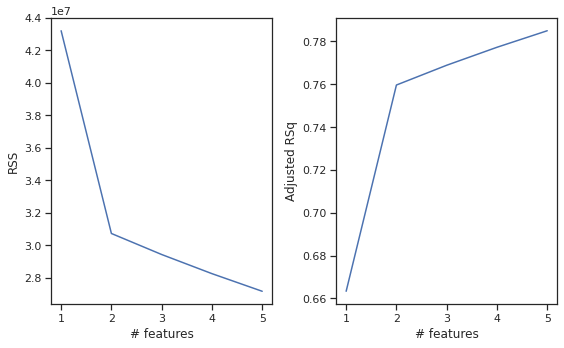

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5))
ax1.plot(models["RSS"])
ax1.set_xlabel('# features')
ax1.set_ylabel('RSS')
ax2.plot(models["adjr2"])
ax2.set_xlabel('# features')
ax2.set_ylabel('Adjusted RSq')
plt.tight_layout()
plt.show()

Plotting RSS, adjusted $R^2$, $C_p$, and BIC for all of the models at once will help us decide which model to select.

In a similar fashion we can plot the AIC and BIC statistics, and indicate the models with the smallest statistic using `which.min()`.

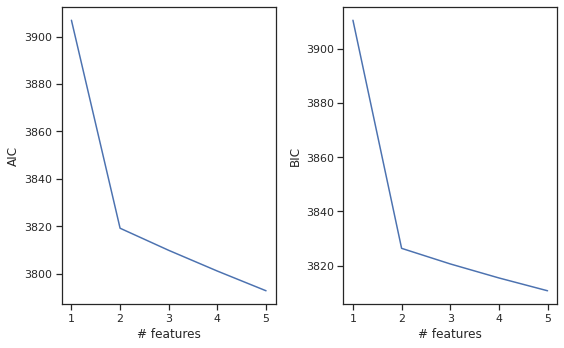

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,5))
ax1.plot(models["aic"])
ax1.set_xlabel('# features')
ax1.set_ylabel('AIC')
ax2.plot(models["bic"])
ax2.set_xlabel('# features')
ax2.set_ylabel('BIC')
plt.tight_layout()
plt.show()

The top row of each plot contains a black square for each variable selected according to the optimal model associated with that statistic. For instance, we see that several models share a BIC close to $-150$. However, the model with the lowest BIC is the six-variable model that contains only `AtBat`,
`Hits`,  `Walks`, `CRBI`, `DivisionW`, and `PutOuts`.
We can use the `coef()` function to see the coefficient estimates associated with this model.

### Forward and Backward Stepwise Selection

We can also use the `forward_select()` and `backward_select()` function to perform forward stepwise or backward stepwise selection.

### Forward Stepwise Selection

In [12]:
# we can use the previous user defined function 'def getRSS(y, X, feature_list)' 
# to add 1 feature at a time (start from 0 feature) for forward stepwise selection
# or delete 1 feature at a time(start from all the features) for backward stepwise selection. 
def forward_select(y, X, feature_list):
    remaining_predictors = [p for p in X.columns if p not in feature_list]
    results = []
    for p in remaining_predictors:
        results.append(getRSS(y, X, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model

In [13]:
models2 = pd.DataFrame(columns=["RSS", "Model"])
feature_list = []
for i in range(1,len(X.columns)+1):
    models2.loc[i] = forward_select(y, X, feature_list)
    feature_list = models2.loc[i]["Model"].model.exog_names

In [14]:
# we can compare the results of best subset selection and the forward selection
print('Best max_feature variable from best subset selection on tranining')
print(models.loc[max_feature, 'Model'].params)
print('\n---------------------------------------------')
print('Best max_feature variable from forward selection on tranining')
print(models2.loc[max_feature, 'Model'].params)

Best max_feature variable from best subset selection on tranining
AtBat          -1.571703
Hits            7.443980
CRBI            0.684000
PutOuts         0.288405
Division_E    124.035287
dtype: float64

---------------------------------------------
Best max_feature variable from forward selection on tranining
Hits            7.443980
CRBI            0.684000
PutOuts         0.288405
AtBat          -1.571703
Division_E    124.035287
dtype: float64


For instance, we see that using forward stepwise selection, the best one-variable model contains only `CRBI`, and the best two-variable model additionally includes `Hits`. For this data, the best one-variable through six-variable models are each identical for best subset and forward selection. However, the best seven-variable models identified by forward stepwise selection, backward stepwise selection, and best subset selection are different.

### Backward Stepwise Selection

In [15]:
def backward_select(y, X, feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1):
        results.append(getRSS(y, X, combo))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model  

In [16]:
# the backward selection starts from all the variables of features
models3 = pd.DataFrame(columns=["RSS", "Model"], index = range(1,len(X.columns)))
feature_list = X.columns

while(len(feature_list) > 1):
    models3.loc[len(feature_list)-1] = backward_select(y, X, feature_list)
    feature_list = models3.loc[len(feature_list)-1]["Model"].model.exog_names

print(models3.loc[max_feature, "Model"].params)

AtBat     -1.899448
Hits       7.754626
Walks      3.687280
CRuns      0.624463
PutOuts    0.301334
dtype: float64


## 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation

In previous sections, we defined the 'best' model based on some statistics (R^2, adj R^2, AIC, BIC, etc) of the training dataset. This may cause 'overfitting' problem which means the best model on training data can not generalize well to new data. In this section, validation approach will be discussed.


### Choosing Among Models Using the Validation-Set Approach and Cross-Validation

We just saw that it is possible to choose among a set of models of different sizes using AIC, BIC, and adjusted $R^2$. We will now consider how to do this using the validation set and cross-validation approaches.

In order for these approaches to yield accurate estimates of the test error, we must use *only the training observations* to perform all aspects of model-fitting---including variable  selection.  Therefore, the determination of which model of a
given size is best must be made using *only the training observations*. This point is subtle but important. 
If the full data set is used to perform the best subset selection step, the validation set errors and cross-validation errors that we obtain will not be accurate estimates of the test error.

In order to use the validation set approach, we begin by splitting the observations into a training set and a test set.  

In [17]:
# randomly split the data into traning dataset and validation dateset
np.random.seed(seed = 21)
train_index = np.random.choice([True, False], size = len(y), replace = True, p = [0.7, 0.3]) 
# random select ~70% of data into traning sample
# the rest of the samples will be in testing set.
test_index = np.invert(train_index)
X_train= X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]

In [18]:
from sklearn.feature_selection import SequentialFeatureSelector

lr = LinearRegression()
sfs = SequentialFeatureSelector(lr, cv=10, scoring='neg_mean_squared_error', n_features_to_select='auto')
sfs.fit(X_train, y_train)

sfs.transform(X_train).shape

(171, 9)

In [19]:
sfs.get_support()

array([False, False, False, False,  True,  True,  True, False, False,
       False,  True, False, False,  True, False,  True,  True,  True,
        True])

In [20]:
sfs.get_feature_names_out()

array(['RBI', 'Walks', 'Years', 'CRuns', 'PutOuts', 'Errors', 'League_A',
       'Division_E', 'NewLeague_A'], dtype=object)

We find that the best model is the one that contains nine variables.

This was a little tedious. We can put this into a Pipeline in sklearn.

In [21]:
clf = Pipeline([
  ('feature_selection', SequentialFeatureSelector(LinearRegression(),
                                                  n_features_to_select='auto')),
  ('classification', LinearRegression())
])
clf.fit(X_train, y_train)

Pipeline(steps=[('feature_selection',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select='auto')),
                ('classification', LinearRegression())])

Finally, we perform best subset selection on the full data set, and select the best nine-variable model. It is important that we make use of  the full data set in order to obtain more accurate coefficient estimates. Note that we perform best subset selection on the full data set and select the best nine-variable model, rather than simply using the variables that were obtained from the training set, because the best nine-variable model on the full data set may differ from the corresponding model on the training set.

In [22]:
clf = Pipeline([
  ('feature_selection', SequentialFeatureSelector(LinearRegression(),
                                                  n_features_to_select=9)),
  ('classification', LinearRegression())
])
clf.fit(X, y)

Pipeline(steps=[('feature_selection',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=9)),
                ('classification', LinearRegression())])

In [23]:
clf.score(X, y)

0.4702776325335545

In [24]:
clf[0].get_feature_names_out()

array(['Runs', 'RBI', 'Walks', 'CAtBat', 'CHmRun', 'CRuns', 'CWalks',
       'League_A', 'Division_E'], dtype=object)

In fact, we see that the best nine-variable model on the full data set has a different set of variables than the best nine-variable model on the training set.

We now try to choose among the models of different sizes using cross-validation.
This approach is somewhat involved, as we must perform best subset selection *within each of the $k$ training sets*.

We see that cross-validation selects a 10-variable model. We now perform best subset selection on the full data set in order to obtain the 10-variable model.

## 6.5.2 Ridge Regression and the Lasso

We will use the `sklearn` package in order to perform ridge regression and the lasso.

We will now perform ridge regression and the lasso in order to predict `Salary` on the `Hitters` data. Before proceeding ensure that the missing values have been removed from the data, as described in Section 6.5.1.

In [25]:
# similar to before, we need to prepare the features(indepedent) variables and response(depedent) varisble.
Hitters = pd.read_csv('https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/Hitters.csv', header=0, na_values='NA')
Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])

y = Hitters.Salary  # the response variable 
X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

### Ridge Regression

The `Ridge()` class has an `alpha` argument that determines what type of model is fit. If `alpha=0` then a ridge regression model is fit, and if `alpha=1` then a lasso model is fit. We first fit a ridge regression model.

In [26]:
alphas = 10**np.linspace(10,-2,100)
print(alphas)

[1.00000000e+10 7.56463328e+09 5.72236766e+09 4.32876128e+09
 3.27454916e+09 2.47707636e+09 1.87381742e+09 1.41747416e+09
 1.07226722e+09 8.11130831e+08 6.13590727e+08 4.64158883e+08
 3.51119173e+08 2.65608778e+08 2.00923300e+08 1.51991108e+08
 1.14975700e+08 8.69749003e+07 6.57933225e+07 4.97702356e+07
 3.76493581e+07 2.84803587e+07 2.15443469e+07 1.62975083e+07
 1.23284674e+07 9.32603347e+06 7.05480231e+06 5.33669923e+06
 4.03701726e+06 3.05385551e+06 2.31012970e+06 1.74752840e+06
 1.32194115e+06 1.00000000e+06 7.56463328e+05 5.72236766e+05
 4.32876128e+05 3.27454916e+05 2.47707636e+05 1.87381742e+05
 1.41747416e+05 1.07226722e+05 8.11130831e+04 6.13590727e+04
 4.64158883e+04 3.51119173e+04 2.65608778e+04 2.00923300e+04
 1.51991108e+04 1.14975700e+04 8.69749003e+03 6.57933225e+03
 4.97702356e+03 3.76493581e+03 2.84803587e+03 2.15443469e+03
 1.62975083e+03 1.23284674e+03 9.32603347e+02 7.05480231e+02
 5.33669923e+02 4.03701726e+02 3.05385551e+02 2.31012970e+02
 1.74752840e+02 1.321941

However, here we have chosen to implement the function over a grid of values ranging from $\lambda=10^{10}$ to $\lambda=10^{-2}$, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit. As we will see, we can also compute model fits for a particular value of $\lambda$ that is not one of the original `grid` values. 

Associated with each value of $\lambda$ is a vector of ridge regression coefficients, stored in a matrix that can be accessed by `coef()`. In this case, it is a $20 \times 100$ matrix, with $20$ rows (one for each predictor, plus an intercept) and $100$ columns (one for each value of $\lambda$).

In [27]:
# associated with each value of alpha is a vector of ridge regression coefficients, 
# stored in a matrix that can be accessed by coeffs. In this case, it is a 19×100, 
# 19 is the dimension of the features + (intercept needs to call separately) and 100 
# is the len of the alphas. The result is a numpy series with len 100 and len(coffes[0]) is 19. 
# In this specific implementation, the default is no intercept. 
# here I used list to store them, we could also use dictionary to store them as we did before.
ridge = Ridge(fit_intercept=True, normalize=True)
coeffs = []
intercepts = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X, y)
    coeffs.append(ridge.coef_)
    intercepts.append(ridge.intercept_)

In [28]:
print(len(coeffs))
print(len(coeffs[0]))
print(len(intercepts))
print(intercepts[0])

100
19
100
535.9258816915063


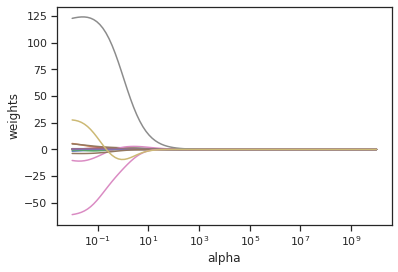

In [29]:
# as design, as alphas get bigger, magnitude of coefficients turn to be closer to zero. 
# one thing to remember is that the decay is quite smooth
ax = plt.gca()
ax.plot(alphas, coeffs)
"""
Typically, we scale the alpha in log scale.
Try to plot it without. 
"""
ax.set_xscale('log') 
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

We expect the coefficient estimates to be much smaller, in terms of $\ell_2$ norm, when a large value of $\lambda$ is used, as compared to when a small value of
$\lambda$ is used. These are the coefficients when $\lambda=11{,}498$, along with their $\ell_2$ norm:

In [30]:
# let us take one example
"""
We may notice the coefficients l2 norm is different from R output 
I tried a few different normalization methods but still did not get the exact same output 
"""
sample = 49
print(alphas[sample])
print(math.sqrt(sum(map(lambda x:x*x, coeffs[sample]))))
print(coeffs[sample])


11497.569953977356
0.015604015364701388
[ 1.05084190e-04  3.81213219e-04  1.53587268e-03  6.44641457e-04
  6.80918080e-04  8.01446032e-04  3.27704404e-03  9.02214059e-06
  3.32048758e-05  2.50408429e-04  6.66164023e-05  6.87496444e-05
  7.27332307e-05  4.21005722e-05  6.87621309e-06 -3.21056660e-05
  1.11649125e-03  1.50775795e-02  2.19838773e-04]


In contrast, here are the coefficients when $\lambda=705$, along with their $\ell_2$ norm. Note the much larger $\ell_2$ norm of the coefficients associated with this smaller value of $\lambda$.

We  now split the samples into a training set and a test set in order to estimate the test error of ridge regression and the lasso. There are two common ways to randomly split a data set. The first is to produce a random vector of `TRUE`, `FALSE` elements and select the observations corresponding to `TRUE` for the training data. The second is to randomly choose a subset of numbers between $1$ and $n$; these can then be used as the indices for the training observations. The two approaches work equally well. We used the former method in Section 6.5.1. Here we demonstrate the latter approach.

We first set a random seed so that the results obtained will be reproducible.

In [31]:
# we now split the samples into a training set and a test set in order to estimate 
# the test error of ridge regression and the lasso. 
# Python provides a built-in function to produce training and test data set.
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.66)

Next we fit a ridge regression model on the training set, and evaluate its MSE on the test set, using $\lambda=4$.  Note the use of the `predict()` function again.

In [32]:
# train the model and do prediction on test dataset
ridge = Ridge(fit_intercept=True, normalize=True, alpha=4)
ridge.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))        # Calculate the test MSE

AtBat           0.140401
Hits            0.502269
HmRun           1.566403
Runs            0.730003
RBI             0.666613
Walks           0.696304
Years           3.540244
CAtBat          0.009477
CHits           0.034620
CHmRun          0.180378
CRuns           0.066102
CRBI            0.058552
CWalks          0.070382
PutOuts         0.024093
Assists         0.017444
Errors          0.132390
League_A       -5.292163
Division_E     18.779448
NewLeague_A   -10.845347
dtype: float64
158169.7986782719


The test MSE is $158{,}798$. 

Note that if we had instead simply fit a model with just an intercept, we would have predicted each test observation using the mean of the training observations. In that case, we could compute the test set MSE like this:

In [33]:
((y_test - y_train.mean())**2).mean()

237526.7450487441

So fitting a ridge regression model with $\lambda=4$ leads to a much lower test MSE than fitting a model with just an intercept.
We now check whether there is any benefit to performing ridge regression with $\lambda=4$ instead of just performing least squares regression. Recall that least squares is simply ridge regression with $\lambda=0$.

In [34]:
# train the model and do prediction on test dataset
ridge = Ridge(fit_intercept=True, normalize=True, alpha=0)
ridge.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge.coef_, index=X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))        # Calculate the test MSE

AtBat          -1.036608
Hits            1.247736
HmRun          -1.446054
Runs            1.309007
RBI             4.653507
Walks           4.880508
Years          -3.320797
CAtBat         -0.102341
CHits           1.829129
CHmRun          3.606345
CRuns          -0.894601
CRBI           -1.835604
CWalks         -0.517837
PutOuts         0.116911
Assists         0.206200
Errors         -2.551689
League_A       20.427276
Division_E     99.136556
NewLeague_A   -55.599948
dtype: float64
143859.24905103864


This represents a further improvement over the test MSE that we got using $\lambda=4$.
Finally, we refit our ridge regression model on the full data set, using the value of $\lambda$ chosen by cross-validation, and examine the coefficient estimates.

In [35]:
# to select best alpha, we will use cross validation. 
# as standard, we will report test set performance as the final performance metric
ridgecv =  RidgeCV(alphas, scoring='neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

2.009233002565046

In [36]:
# produce the mean squred error of the selected alpha on test dataset
ridge_best = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge_best.fit(X_train, y_train)
mean_squared_error(y_test, ridge_best.predict(X_test))

149456.41864238377

In [37]:
# we can exame the values of the coefficients 
pd.Series(ridge_best.coef_, index=X.columns)

AtBat           0.169999
Hits            0.639215
HmRun           1.878439
Runs            0.906496
RBI             0.810615
Walks           0.820017
Years           4.334067
CAtBat          0.011820
CHits           0.044248
CHmRun          0.191351
CRuns           0.082013
CRBI            0.069101
CWalks          0.074531
PutOuts         0.032628
Assists         0.020510
Errors          0.124686
League_A       -9.452157
Division_E     30.012946
NewLeague_A   -17.974926
dtype: float64

As expected, none of the coefficients are zero---ridge regression does not perform variable selection!

### The Lasso

We saw that ridge regression with a wise choice of $\lambda$ can outperform least squares as well as the null model on the `Hitters` data set. We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression. Other than that change, we proceed just as we did in fitting a ridge model.

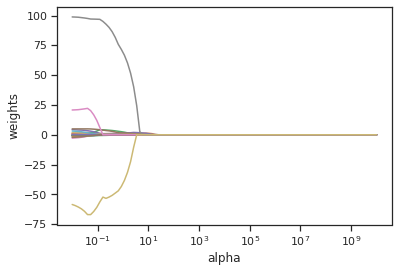

156759.698816488


In [38]:
# same precedure as before, we will use cross validation to select the best alpha
lasso= Lasso(normalize=True, max_iter=int(1e5))
coeffs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coeffs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas, coeffs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

lassocv = LassoCV(alphas=None, cv=10, max_iter=int(1e5), normalize=True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
print(mean_squared_error(y_test, lasso.predict(X_test)))

We can see from the coefficient plot that depending on the choice of tuning parameter, some of the coefficients will be exactly equal to zero.
We now perform cross-validation and compute the associated test error.

In [39]:
# some of the coefficients should reduce to exact zero
pd.Series(lasso.coef_, index=X.columns)

AtBat          0.000000
Hits           1.154708
HmRun          0.000000
Runs           0.805094
RBI            1.492200
Walks          0.184973
Years          0.000000
CAtBat         0.000000
CHits          0.227180
CHmRun         0.000000
CRuns          0.000000
CRBI           0.000000
CWalks         0.000000
PutOuts        0.000000
Assists        0.000000
Errors         0.000000
League_A      -0.000000
Division_E     0.000000
NewLeague_A   -0.000000
dtype: float64

This is substantially lower than the test set MSE of the null model and of least squares, and very similar to the test MSE of ridge regression with $\lambda$ chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in that the resulting coefficient estimates are sparse. Here we see that 8 of the 19 coefficient estimates are exactly
zero. So the lasso model with $\lambda$ chosen by cross-validation contains only eleven variables.

## 6.5.3 PCR and PLS Regression

### Principal Components Regression
Principal components regression (PCR) can be performed using the PCA function + regression afterwards. The PCA function is part of the scikit-learn module. In this section, we will continue using Hitters data, in order to predict Salary. Again, we will drop NA and deal with the categorical variables from the data set as what we did in Section 6.5. 

In [40]:
Hitters = pd.read_csv('https://raw.githubusercontent.com/tvanzyl/Sharing_ISL_python/master/data/Hitters.csv', header=0, na_values='NA')
Hitters = Hitters.dropna().reset_index(drop=True) # drop the observation with NA values and reindex the obs from 0
y = Hitters.Salary  # the response variable 
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])
X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

In [41]:
# let us do PCA on the input dataset. 
# since the units of the variables are different, it is always recommended to scale the variables.
pca = PCA()
X_pca = pca.fit_transform(scale(X))
regr = linear_model.LinearRegression()

We now apply PCR to the `Hitters` data, in order to predict `Salary`. Again,  we ensure that the missing values have been removed from the data, as described in Section 6.5.1.

The syntax for the `pcr()` function is similar to that for `lm()`, with a few additional
options. Setting `scale = TRUE` has the effect of *standardizing* each
predictor, using ( 6.6), prior to generating the principal
components, so that the scale on which each variable is measured will not have an effect.
 Setting `validation = "CV"` causes
`pcr()` to compute the ten-fold cross-validation error for each possible
value of $M$, the number of principal components used. The resulting fit can be examined using `summary()`.

The CV score is provided for each possible number of components, ranging
from $M=0$ onwards. (We have printed the CV output only up to $M=4$.)
Note that  `pcr()` reports the *root mean squared error*; in order to obtain the usual MSE, we must square this quantity. For instance, a root mean squared error of $352.8$ corresponds to an MSE of
$352.8^2=124{,}468$.

One can also plot the cross-validation scores using the
`validationplot()` function. Using `val.type = "MSEP"`
will cause the cross-validation MSE to be plotted.

In [42]:
"""
Here comes a problem, how to choose the number of PCs. We still use cross-validation. 
We compute MSE for validation set at different number of PCs, 
and choose the one with lowest validation MSE as the optimal number for PCA dimension reduction. 

[NOT fully covered here, covered in Chapter 12] We may decide on the number of PCS by the explained variance ratio.
"""

def pcr(X,y,pc):
    ''' Principal Component Regression in Python'''
    ''' Step 1: PCA on input data'''

    # Define the PCA object
    pca = PCA()

    # Preprocessing (1): first derivative
    X_pca = pca.fit_transform(scale(X))[:,:pc]

    ''' Step 2: regression on selected principal components'''

    # Create linear regression object
    regr = linear_model.LinearRegression()
    
    # Fit
    regr.fit(X_pca, y)

    # Calibration
    y_train = regr.predict(X_pca)

    # Cross-validation
    y_cv = cross_val_predict(regr, X_pca, y, cv=20)

    # Calculate scores for training and cross-validation
    score_train = r2_score(y, y_train)
    score_cv = r2_score(y, y_cv)

    # Calculate mean square error for training and cross validation
    mse_train = mean_squared_error(y, y_train)
    mse_cv = mean_squared_error(y, y_cv)

    return(y_cv, score_train, score_cv, mse_train, mse_cv)


We see that the smallest cross-validation error occurs when $M=18$ components are used. This is barely fewer than $M=19$, which amounts to simply performing least squares, because when all of the components are used in PCR no dimension reduction occurs. However, from the plot we also see that the cross-validation error is roughly the same when only one component is included in the model. This suggests that a model that uses just a small number of components might suffice.

 The
`summary()` function also provides the *percentage of variance explained* in the predictors and in the response using different numbers of components. This concept is discussed in greater detail in Chapter 12.
   Briefly, we can think of this as
the amount of information about the predictors or the
response that is captured using $M$ principal components. For example,
setting $M=1$ only captures $38.31\,\%$ of all the variance, or information,
in the predictors. In contrast, using $M=5$ increases the value to $84.29\,\%$. If we
were to use all $M=p=19$ components, this would increase to $100\,\%$.

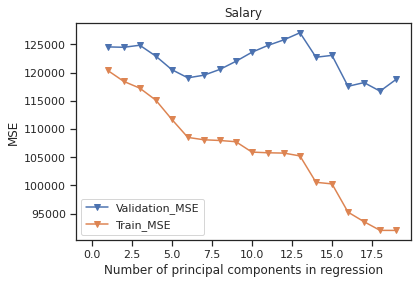

In [43]:
mse_train = []
mse_cv = []

# calculate MSE using CV for the 19 principle components, adding one component at the time.
for i in np.arange(1, 20):
    results =  pcr(X,y,i)
    mse_train.append(results[3])
    mse_cv.append(results[4])
    
# plot results    
plt.plot(np.arange(1, 20), mse_cv, '-v', label = 'Validation_MSE')
plt.plot(np.arange(1, 20), mse_train, '-v', label = 'Train_MSE')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(left=-1)
plt.legend()
plt.show()

From the above picture, we can observe three things 

1) PC = 6, 16, 17, 18, 19 give us the small validation MSE; 
2) for all the PC dimensions,  validation MSE is higher than training MSE, is this normal? 
3) the training MSE keeps decreasing as PC number goes up, is this as expected?


From the plot we also see that the cross-validation error is roughly the same when 
only one component is included in the model. 
This suggests that a model that uses just a small number of components might suffice. 
In the book, the authors used train/test to select the best dimension. 
I will skip that part since most of those were already covered in the previous sections.

We now perform PCR on the training data and evaluate its test set performance.

This test set MSE is competitive with the results obtained using ridge regression and the lasso. However, as a result of the way PCR is implemented, the final model is more difficult to interpret because it does not perform any kind of variable selection or even directly produce coefficient estimates.

Finally, we fit PCR on the full data set, using $M=6$, the number of components identified by cross-validation.

In [44]:
# let us move forwward with 6 PCs
pcs = 6
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.66)

pca2 = PCA()
# scale the data
X_reduced_train = pca2.fit_transform(scale(X_train))
X_reduced_test = pca2.transform(scale(X_test))[:,:pcs]
# train regression model on training data 
regr = linear_model.LinearRegression()
regr.fit(X_reduced_train[:,:6], y_train)
# prediction with test data
pred = regr.predict(X_reduced_test)
mean_squared_error(y_test, pred)

107276.07631078806

Now we find that the lowest cross-validation error occurs when $M=6$ components are used. 
We compute the test MSE as follows.

We'll do a little math to get the amount of variance explained by adding each consecutive principal component. 
We can think of this as the amount of information(variance) about the data(X) or the response that is 
captured using $M$ principal components. For example, setting $M = 1$ only captures 38.31% of all the variance, or information, in the data.

In [45]:
np.cumsum(pca.explained_variance_ratio_) * 100

array([ 38.31423957,  60.15531541,  70.8416746 ,  79.03419435,
        84.29027516,  88.63477938,  92.26288766,  94.96304322,
        96.28269124,  97.25541298,  97.97775424,  98.64870031,
        99.15178693,  99.4730334 ,  99.74659124,  99.89398793,
        99.96815949,  99.99375108, 100.        ])

### Partial Least Squares

Scikit-learn has function PLSRegression for partial least squares regression. 

In [46]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.66)
pls = PLSRegression(n_components=2)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

174126.72168654652

But, we still need to write a few line of codes to do the cross validation. The logic is same as before. 

In [47]:
#TODO Exercise

The lowest cross-validation error occurs when only $M=1$ partial least squares directions are used. We now evaluate the corresponding test set MSE.

The test MSE is comparable to, but slightly higher than, the test MSE obtained using ridge regression, the lasso, and PCR.
Finally, perform PLS using the full data set, using $M=1$, the number of components identified by cross-validation.

In [48]:
#TODO Exercise

Notice that the percentage of variance in `Salary` that the one-component PLS fit explains, $43.05\,\%$, is almost as much as that explained using the final five-component model PCR fit, $44.90\,\%$. This is because PCR only attempts to maximize the amount of variance explained in the predictors, while PLS searches for directions that explain variance in both the predictors and the response.

In [49]:
# End of Chapter 6